Given a list of papers create a report:

 

1. Generate groups of similar papers and assign a meaningful label or group of tags to each group.

2. Outline what papers inside each group represent that group.

3. For each paper, provide a brief "one-liner" description of what is the paper main contribution or innovation.

4. Identify papers that represent potential breakthroughs.

In [1]:
import numpy
from bs4 import BeautifulSoup as bso
import requests
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ninakuklisova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# process the XML input

soup_20200211 = bso(open('mendeley_document_library_2020-02-11.xml'), 'html.parser')

soup_20200217 = bso(open('mendeley_document_library_2020-02-17.xml'), 'html.parser')

soup_20200225 = bso(open('mendeley_document_library_2020-02-25.xml'), 'html.parser')

soup_20200302 = bso(open('mendeley_document_library_2020-03-02.xml'), 'html.parser')

soup_20200310 = bso(open('mendeley_document_library_2020-03-10.xml'), 'html.parser')

soup_20200316 = bso(open('mendeley_document_library_2020-03-16.xml'), 'html.parser')

soup_objects = [soup_20200211, soup_20200217, soup_20200225, soup_20200302, soup_20200310, soup_20200316]



In [3]:
# clean the abstract text
# this will need to be done multiple times, so I created a function

def abstract_text_clean(abstract_text_input):
    for c in ('\n', '<p>', '<\p>', '<\p>', '<bold>', '</bold>', '###'):
        abstract_text_input = abstract_text_input.replace(c, '')

    

    for x in ('BACKGROUND', 'Background', 'Backgrounds', 'Abstract', 'ABSTRACT', 'Results', 'RESULTS', 'Findings', 'FINDINGS', 'Conclusions', 'CONCLUSIONS', 'Conclusion', 'Teaser', 'Methods', 'Objective', 'Result', ':'):
        abstract_text_input = abstract_text_input.replace(x, '')
    
    
    # these sentences were often occurring, not helpful:
    # Yes I have followed all appropriate research reporting guidelines and uploaded the relevant EQUATOR Network research reporting checklist(s) and other pertinent material as supplementary files, if applicable.
    abstract_text_input = abstract_text_input.replace('I have followed all appropriate research reporting guidelines and uploaded the relevant EQUATOR Network research reporting checklist(s) and other pertinent material as supplementary files, if applicable.', '')
    
    abstract_text_input = abstract_text_input.replace('I understand that all clinical trials and any other prospective interventional studies must be registered with an ICMJE-approved registry, such as ClinicalTrials.gov.', '')
    abstract_text_input = abstract_text_input.replace('Please note that, during the production process, errors may be discovered which could affect the content, and all legal disclaimers that apply to the journal pertain.', '')
    abstract_text_input = abstract_text_input.replace('Competing Interest Statement', '')
    abstract_text_input = abstract_text_input.replace('The authors have declared no competing interest', '')
    
    
    for s in ('Funding Statement', 'Author Declarations', 'All relevant ethical guidelines have been followed; any necessary IRB and/or ethics committee approvals have been obtained and details of the IRB/oversight body are included in the manuscript.', 
              'All necessary patient/participant consent has been obtained and the appropriate institutional forms have been archived.', 'Yes',
              'I confirm that any such study reported in the manuscript has been registered and the trial registration ID is provided', 'note if posting a prospective study registered retrospectively, please provide a statement in the trial ID field explaining why the study was not registered in advance',
              'No funding supported this research', 
              'All data comes from the World Health Organization site, and all statistical calculation data are included as Supplementary Files One approach that is being used is to simply keep adjusting the reproduction number to match the dynamics.',
              'We used only publicly available data.', '()'
              ):
        abstract_text_input = abstract_text_input.replace(s, '')
    
    return(abstract_text_input)



In [4]:
# process the abstract and summarize it

import re
import heapq

def sum_function(abstract_text):
    
    abstract_text = abstract_text_clean(abstract_text)
    
    # remove [], extra spaces
    abstract_text = re.sub(r'\[[0-9]*\]', ' ', abstract_text)
    abstract_text = re.sub(r'\s+', ' ', abstract_text)

    # remove special characters, digits
    formatted_abstract_text = re.sub('[^a-zA-Z]', ' ', abstract_text )
    formatted_abstract_text = re.sub(r'\s+', ' ', formatted_abstract_text)
   
    # do sentence tokenization
    sentence_list = nltk.sent_tokenize(abstract_text)
    
    # find weighted frequency of occurence of words
    stopwords = nltk.corpus.stopwords.words('english')

    word_frequencies = {}
    for word in nltk.word_tokenize(formatted_abstract_text):
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1
    
    try:
        maximum_frequncy = max(word_frequencies.values())
    except:
        pass

    for word in word_frequencies.keys():
        try:
            word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)
        except:
            pass
        
    sentence_scores = {}
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]
                        
    # get the summary
    
    summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(summary_sentences)
    return(summary)

In [5]:
# we process the inputs and summarize what we have

import pandas as pd


l = []
# for now, we are skipping other information about the articles; keywords are not always that helpful.
df = pd.DataFrame(columns=['Title','Secondary Title','Authors','Abstract', 'One-liner summary'])
pos= 0

# this is a generalisation for all xml files
for soup in soup_objects:
    all_articles = soup.find_all('record')
    for record in all_articles:
        try:
            l.append(record.find('full-title').text)
        except:
            l.append('')
            pass
        try:
            l.append(record.find('secondary-title').text)
        except:
            l.append('')
            pass
        try:
            st_authors = record.find('authors')
            l_authors = st_authors.find_all('author')
            authors_t = l_authors[0].text
            l_authors = l_authors[1:]
            for a in l_authors:
                 authors_t += ('; ')    
                 authors_t += (a.text)
            l.append(authors_t)
        except:
            try:
                l.append(st_authors.text)
            except:
                l.append('')
                pass
            pass
        try:
            abst_text = record.find('abstract').text
            l.append(abst_text)
            try:
                one_liner_sum = sum_function(abst_text)
                l.append(one_liner_sum)
            except:
                pass
        except:
            l.append('')
            l.append('')
            pass


        # all article details
        df.loc[pos] = l
        l = []
        pos+=1

In [9]:
# first view of data that we have
df.to_csv('covid_articles.csv')

In [10]:
# drop the rows in this table where there is no abstract, or which are in Mandarin and can't be processed
df = df[ df['One-liner summary'].str.len() > 3 ]
df = df.dropna(how='any', subset=['Authors', 'Abstract'])

In [86]:
# also, drop duplicates
# some articles appear multiple times; 
# that would create a bias in how innovative an article is within its group
# we can identify an article by authors and abstract.
# in order to keep only articles that have both abstract and authors,
# we order by authors column and then remove duplicates, and keep only the last

df.sort_values('Authors', ascending=False).drop_duplicates('Abstract', keep='last')
df.sort_values('Authors', ascending=False).drop_duplicates('One-liner summary', keep='last')
df.to_csv('covid_articles.csv')

In [87]:
# this may not still be perfect - some papers still have the same authors, 
# just with name spelled in a different way, but it did drop about 500 rows.
df = df.reset_index(drop=True)
df.to_csv('covid_articles.csv')

[3 1 1 ... 1 1 1]
[3 1 1 ... 1 1 1]


0.01861728504137784

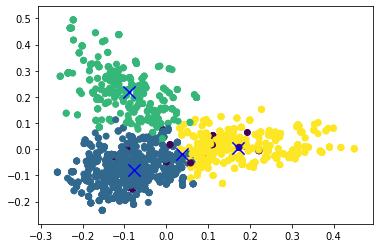

In [88]:
# try 4 clusters
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.datasets import load_files

# for reproducibility
random_state = 0 

# feature extraction

vec = TfidfVectorizer(stop_words="english")
# we need to clean the abstract from unnecessary words and disclosures
clean_abstract = df['Abstract'].apply(abstract_text_clean)
vec.fit(clean_abstract)
features = vec.transform(clean_abstract)

# create the clusters

cls = MiniBatchKMeans(n_clusters=4, random_state=random_state)
cls.fit(features)

# predict cluster labels for new dataset
print(cls.predict(features))

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
print(cls.labels_)

# reduce the features to 2D
pca = PCA(n_components=3, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

# visualize
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

# evaluate this clustering model with a silhouette coefficient
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

[0 1 1 ... 1 1 1]


0.017873013939901494

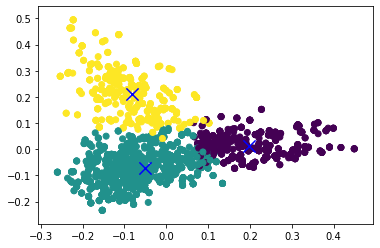

In [89]:
# try with other numbers

# try again with 3 clusters
# for reproducibility
random_state = 0 

# feature extraction

vec = TfidfVectorizer(stop_words="english")
# we need to clean the abstract from unnecessary words and disclosures
clean_abstract = df['Abstract'].apply(abstract_text_clean)
vec.fit(clean_abstract)

features = vec.transform(clean_abstract)

# create the clusters

cls = MiniBatchKMeans(n_clusters=3, random_state=random_state)
cls.fit(features)

# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
print(cls.labels_)

# reduce the features to 2D
pca = PCA(n_components=3, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

# visualize
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

# evaluate this clustering model with a silhouette coefficient
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

[4 1 1 ... 1 1 1]
[4 1 1 ... 1 1 1]


0.018806022242321516

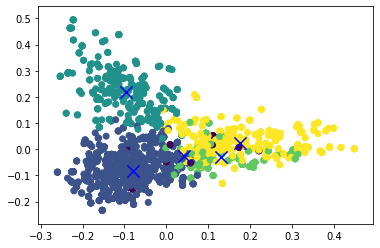

In [90]:
# try 5 clusters
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.datasets import load_files

# for reproducibility
random_state = 0 

# feature extraction

vec = TfidfVectorizer(stop_words="english")
# we need to clean the abstract from unnecessary words and disclosures
clean_abstract = df['Abstract'].apply(abstract_text_clean)
vec.fit(clean_abstract)
features = vec.transform(clean_abstract)

# create the clusters

cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)
cls.fit(features)

# predict cluster labels for new dataset
print(cls.predict(features))

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
print(cls.labels_)

# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

# visualize
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

# evaluate this clustering model with a silhouette coefficient
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

In [91]:
# based on the plots and on the silhouette score,
# it seems that 3 is the most reasonable number of groups to split our dataset into.

In [92]:
# now, we need to identify the topics of these clusters

In [93]:
# let's try LDA
# Also, let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

clean_abstract = df['Abstract'].apply(abstract_text_clean)

# this is based on finding what words do all topics have in common

common_covid_words = ['2020', '2019', 'coronavirus','19', 'munuscript', 'patients', 'patient', 'reporting', 
                      'number', 'wuhan', 'china', 'data', 'statement', 'yes', 'study', 'research', 'registered', 
                      'covid', 'human', 'hospital', 'health', 'hubei', 'sars', 'cov', 'ncov',
                     'january', 'february', 'transmission']
# Add new stop words
stop_words_covid = text.ENGLISH_STOP_WORDS.union(common_covid_words)


#count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words=stop_words_covid)
doc_term_matrix = count_vect.fit_transform(clean_abstract.values.astype('U'))

In [94]:
from sklearn.decomposition import LatentDirichletAllocation

# we launch LDA with 3 different topics
LDA = LatentDirichletAllocation(n_components=3, random_state=0)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=3, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [95]:
import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])

deeppneumonia
ro
communicate
tract
ilinet
intermediate
handle
pathogenicity
fangcang
cavity


In [96]:
first_topic = LDA.components_[0]

In [97]:
top_topic_words = first_topic.argsort()[-10:]

In [98]:
top_topic_words

array([8783, 3408, 5952, 3113, 7874, 2753, 6098, 1272, 3793, 2295])

In [99]:
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

time
disease
model
days
science
confirmed
national
95
epidemic
cases


In [100]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 20 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

Top 20 words for topic #0:
['rate', 'risk', 'infected', 'control', 'novel', 'estimated', 'outbreak', 'ci', 'available', 'province', 'time', 'disease', 'model', 'days', 'science', 'confirmed', 'national', '95', 'epidemic', 'cases']


Top 20 words for topic #1:
['characteristics', 'fever', 'syndrome', 'symptoms', 'pcr', 'ct', 'acute', 'viral', 'laboratory', 'cells', 'treatment', 'confirmed', 'disease', 'novel', 'infection', 'pneumonia', 'respiratory', 'severe', 'cases', 'clinical']


Top 20 words for topic #2:
['using', 'available', 'coronaviruses', 'control', 'model', 'based', 'potential', 'disease', 'epidemic', 'protein', 'viral', 'infection', 'new', 'public', 'spread', 'countries', 'cases', 'novel', 'virus', 'outbreak']




So, based on these top words for each topic, we have 3 main topics:
    - topic 0: how the virus spreads, modeling the dynamics
    - topic 1: DNA structure of the virus and cells that it attacks
    - topic 2: overall physiological effects of the virus
    

In [101]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(2552, 3)

In [102]:
# now, we classify each article into one if these 3 categories

df['Topic'] = topic_values.argmax(axis=1)

In [103]:
# we export this into a csv file, so that we can review this
df.to_csv('covid_articles.csv')

In [104]:
# Now, we will:
# - within each cluster, find which articles are in the middle (those summarize it the best)
# - within each cluster, find which articles are the furthest from the middle:
#    those can be the most innovative within their group

In [105]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(common_covid_words)

In [107]:
# we process the abstracts again

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(clean_abstract))

print(data_words[:1])

[['the', 'beginning', 'of', 'has', 'seen', 'the', 'emergence', 'of', 'the', 'novel', 'coronavirus', 'ncov', 'outbreak', 'since', 'the', 'first', 'reported', 'case', 'in', 'the', 'wuhan', 'city', 'of', 'china', 'ncov', 'has', 'spread', 'to', 'other', 'cities', 'in', 'china', 'as', 'well', 'as', 'to', 'multiple', 'countries', 'across', 'four', 'continents', 'there', 'is', 'an', 'imminent', 'need', 'to', 'better', 'understand', 'this', 'novel', 'virus', 'and', 'to', 'develop', 'ways', 'to', 'control', 'its', 'spread', 'in', 'this', 'study', 'we', 'sought', 'to', 'gain', 'insights', 'for', 'vaccine', 'design', 'against', 'ncov', 'by', 'considering', 'the', 'high', 'genetic', 'similarity', 'between', 'ncov', 'and', 'the', 'severe', 'acute', 'respiratory', 'syndrome', 'coronavirus', 'sars', 'cov', 'and', 'leveraging', 'existing', 'immunological', 'studies', 'of', 'sars', 'cov', 'by', 'screening', 'the', 'experimentally', 'determined', 'sars', 'cov', 'derived', 'cell', 'and', 'cell', 'epitope

In [108]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'beginning', 'of', 'has', 'seen', 'the', 'emergence', 'of', 'the', 'novel', 'coronavirus', 'ncov', 'outbreak', 'since', 'the', 'first', 'reported', 'case', 'in', 'the', 'wuhan', 'city', 'of', 'china', 'ncov', 'has', 'spread', 'to', 'other', 'cities', 'in', 'china', 'as', 'well', 'as', 'to', 'multiple', 'countries', 'across', 'four', 'continents', 'there', 'is', 'an', 'imminent_need', 'to', 'better_understand', 'this', 'novel', 'virus', 'and', 'to', 'develop', 'ways', 'to', 'control', 'its', 'spread', 'in', 'this', 'study', 'we', 'sought', 'to', 'gain_insights', 'for', 'vaccine', 'design', 'against', 'ncov', 'by', 'considering', 'the', 'high', 'genetic_similarity', 'between', 'ncov', 'and', 'the', 'severe', 'acute', 'respiratory', 'syndrome', 'coronavirus', 'sars', 'cov', 'and', 'leveraging_existing_immunological', 'studies', 'of', 'sars', 'cov', 'by', 'screening', 'the', 'experimentally_determined', 'sars', 'cov', 'derived', 'cell', 'and', 'cell', 'epitopes', 'in', 'the', 'immu

In [109]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [110]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['begin', 'see', 'emergence', 'novel', 'outbreak', 'first', 'report', 'case', 'city', 'spread', 'city', 'well', 'multiple', 'country', 'continent', 'novel', 'virus', 'develop', 'way', 'control', 'spread', 'seek', 'gain_insight', 'vaccine', 'design', 'consider', 'high', 'genetic', 'similarity', 'severe', 'acute', 'immunological', 'study', 'screen', 'experimentally_determine', 'derived', 'cell', 'cell', 'epitope', 'immunogenic', 'structural', 'protein', 'identify', 'set', 'cell', 'cell', 'epitope', 'derive', 'spike', 'protein', 'mutation', 'observe', 'identify', 'epitope', 'available', 'sequence', 'immune', 'target', 'epitope', 'may', 'potentially', 'offer_protection', 'cell', 'epitope', 'perform', 'population', 'coverage', 'analysis', 'associate', 'propose', 'set', 'epitope', 'estimate', 'provide', 'broad_coverage', 'globally', 'well', 'finding', 'provide', 'screened', 'set', 'epitope', 'help', 'guide', 'experimental', 'effort', 'development', 'vaccine']]


In [111]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 5), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 7), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 2)]]


In [112]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [113]:
# Print the Keyword in the 3 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"case" + 0.016*"model" + 0.014*"estimate" + 0.014*"epidemic" + '
  '0.013*"use" + 0.011*"outbreak" + 0.010*"infection" + 0.009*"city" + '
  '0.008*"control" + 0.008*"report"'),
 (1,
  '0.020*"clinical" + 0.018*"case" + 0.013*"severe" + 0.011*"disease" + '
  '0.009*"group" + 0.009*"high" + 0.009*"age" + 0.008*"symptom" + '
  '0.008*"include" + 0.008*"infection"'),
 (2,
  '0.019*"virus" + 0.014*"cell" + 0.013*"protein" + 0.009*"viral" + '
  '0.009*"sequence" + 0.009*"use" + 0.009*"infection" + 0.008*"receptor" + '
  '0.008*"cause" + 0.008*"ace"')]


In [114]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.917356926413271

Coherence Score:  0.5013872683064488


In [115]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.078388  0.148838       1        1  44.540497
1     -0.116588 -0.130589       2        1  29.049946
2      0.194976 -0.018249       3        1  26.409557, topic_info=         Term         Freq        Total Category  logprob  loglift
612  clinical  1501.000000  1501.000000  Default  30.0000  30.0000
22   estimate  1468.000000  1468.000000  Default  29.0000  29.0000
65      virus  1614.000000  1614.000000  Default  28.0000  28.0000
48    protein   866.000000   866.000000  Default  27.0000  27.0000
6        case  4078.000000  4078.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
161      show   339.589417   905.924316   Topic3  -5.1816   0.3502
1    analysis   309.136292   879.511963   Topic3  -5.2755   0.2859
301      find   292.986755   727.477844   Topic3  -5.3292   0.4220
335    result   288.524719   867.751221   Topic3  -5.3445   0.2303
43   outbreak   298.653625  1520.218262   Topic3  -5.3100  -0.2959

[240 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
522       3  0.999452        ace
1091      2  0.997294  admission
1092      2  0.991312      admit
603       1  0.010565      adult
603       2  0.993096      adult
...     ...       ...        ...
1301      1  0.990231    website
766       2  0.990374      woman
665       1  0.049233       year
665       2  0.845169       year
665       3  0.106672       year

[357 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [116]:
for c in lda_model[corpus[0:8]]:
    print("Document Topics      : ", c[0])      # [(Topics, Perc Contrib)]
    print("Word id, Topics      : ", c[1][:3])  # [(Word id, [Topics])]
    print("Phi Values (word id) : ", c[2][:2])  # [(Word id, [(Topic, Phi Value)])]
    print("------------------------------------------------------\n")

Document Topics      :  [(0, 0.10912359), (2, 0.8898286)]
Word id, Topics      :  [(0, [2]), (1, [2, 0]), (2, [2, 0])]
Phi Values (word id) :  [(0, [(2, 0.993001)]), (1, [(0, 0.059333917), (2, 0.9406412)])]
------------------------------------------------------

Document Topics      :  [(0, 0.9933214)]
Word id, Topics      :  [(6, [0]), (22, [0]), (68, [0])]
Phi Values (word id) :  [(6, [(0, 1.9999906)]), (22, [(0, 0.9999917)])]
------------------------------------------------------

Document Topics      :  [(0, 0.99762946)]
Word id, Topics      :  [(1, [0]), (6, [0]), (8, [0])]
Phi Values (word id) :  [(1, [(0, 0.9999563)]), (6, [(0, 2.9999866)])]
------------------------------------------------------

Document Topics      :  [(0, 0.9973282)]
Word id, Topics      :  [(1, [0]), (3, [0]), (6, [0])]
Phi Values (word id) :  [(1, [(0, 0.9999562)]), (3, [(0, 0.99998075)])]
------------------------------------------------------

Document Topics      :  [(0, 0.99600315)]
Word id, Topics      

In [117]:
# to find the documents that are the most representative of the 3 topics,
# we select the documents with the 5 highest probabilities of the given topic

In [118]:
len(corpus[:])

2552

In [119]:
len(df['Abstract'])

2552

In [120]:
lda_model[corpus[0]][0]

[(0, 0.10912063), (2, 0.88983166)]

In [121]:
nan_df = df[df['Abstract'] == '']
nan_df.to_csv('nans.csv')

In [122]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['Abstract']):
    # Init output
    cov_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                cov_topics_df = cov_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    cov_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original Abstract to the end of the output
    contents = pd.Series(texts)
    cov_topics_df = pd.concat([cov_topics_df, contents], axis=1)
    return(cov_topics_df)

df_cov_topics_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['Abstract'])

# Format
df_dominant_topic = df_cov_topics_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Abstract']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Abstract
0,0,2.0,0.8898,"virus, cell, protein, viral, sequence, use, in...",The beginning of 2020 has seen the emergence o...
1,1,0.0,0.9933,"case, model, estimate, epidemic, use, outbreak...","As of 8am 30th January (Beijing Time) 2020, Ap..."
2,2,0.0,0.9976,"case, model, estimate, epidemic, use, outbreak...",The outbreak of pneumonia caused by a novel co...
3,3,0.0,0.9973,"case, model, estimate, epidemic, use, outbreak...",This paper attempts to evaluate the impact of ...
4,4,0.0,0.9960,"case, model, estimate, epidemic, use, outbreak...","Currently, a novel coronavirus 2019-nCoV cause..."
5,5,0.0,0.9979,"case, model, estimate, epidemic, use, outbreak...",Since the first case of new coronavirus (2019-...
6,6,2.0,0.8094,"virus, cell, protein, viral, sequence, use, in...","Viruses evolve extremely quickly, so reliable ..."
7,7,2.0,0.9960,"virus, cell, protein, viral, sequence, use, in...",The 2019 novel coronavirus (2019-nCoV) outbrea...
8,8,2.0,0.9860,"virus, cell, protein, viral, sequence, use, in...",Using a method for pathogen screening in DNA s...
9,9,2.0,0.9115,"virus, cell, protein, viral, sequence, use, in...",The infection of a novel coronavirus found in ...


In [130]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['Abstract'], authors = df['Authors'], summary = df['One-liner summary'], journal = df['Title']):
    # Init output
    cov_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                cov_topics_df = cov_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    cov_topics_df.columns = ['Dominant_Topic', 'Topic_Perc_Fit', 'Topic_Keywords']

    # Add original text to the end of the output
    contents0 = pd.Series(texts)
    # Add the one-liner summary, authors and journal
    contents1 = pd.Series(summary)
    contents2 = pd.Series(authors)
    contents3 = pd.Series(journal)
    cov_topics_df = pd.concat([cov_topics_df, contents0, contents1, contents2, contents3], axis=1)
    return(cov_topics_df)


df_cov_topics_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['Abstract'], authors = df['Authors'], summary = df['One-liner summary'], journal = df['Title'])

# Format
df_dominant_topic = df_cov_topics_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Fit', 'Keywords', 'Abstract','One-liner summary','Authors', 'Publishing Journal' ]

# Show
df_dominant_topic.to_csv('topics.csv')
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Fit,Keywords,Abstract,One-liner summary,Authors,Publishing Journal
0,0,2.0,0.8898,"virus, cell, protein, viral, sequence, use, in...",The beginning of 2020 has seen the emergence o...,Our findings provide a screened set of epitope...,"Ahmed, Syed Faraz; Quadeer, Ahmed A; McKay, Ma...",bioRxiv
1,1,0.0,0.9933,"case, model, estimate, epidemic, use, outbreak...","As of 8am 30th January (Beijing Time) 2020, Ap...","By SEIR simulation, the predicted epidemic pea...","Ai, Lizhe",medRxiv
2,2,0.0,0.9976,"case, model, estimate, epidemic, use, outbreak...",The outbreak of pneumonia caused by a novel co...,"The funder had no role in study design, data c...","Ai, Siqi; Zhu, Guanghu; Tian, Fei; Li, Huan; G...",medRxiv
3,3,0.0,0.9973,"case, model, estimate, epidemic, use, outbreak...",This paper attempts to evaluate the impact of ...,This paper attempts to evaluate the impact of ...,"Arturo, Mario; Estrada, Ruiz; Author, Third; A...",The Lancet
4,4,0.0,0.9960,"case, model, estimate, epidemic, use, outbreak...","Currently, a novel coronavirus 2019-nCoV cause...",These values help to inform case definitions f...,"Backer, Jantien A; Klinkenberg, Don; Wallinga,...",medRxiv
5,5,0.0,0.9979,"case, model, estimate, epidemic, use, outbreak...",Since the first case of new coronavirus (2019-...,"In this paper, we select the epidemic situatio...","Bai, Yuxiao; Nie, Xun; Wen, Chenxin",
6,6,2.0,0.8094,"virus, cell, protein, viral, sequence, use, in...","Viruses evolve extremely quickly, so reliable ...","Viruses evolve extremely quickly, so reliable ...","Bartoszewicz, Jakub M; Seidel, Anja; Renard, B...",bioRxiv
7,7,2.0,0.9960,"virus, cell, protein, viral, sequence, use, in...",The 2019 novel coronavirus (2019-nCoV) outbrea...,"We identified five CTL epitopes, three sequent...","Baruah, V; Bose, S",Journal of medical virology
8,8,2.0,0.9860,"virus, cell, protein, viral, sequence, use, in...",Using a method for pathogen screening in DNA s...,We find three main regions of unique sequence ...,"Beal, Jacob; Mitchell, Thomas; Wyschogrod, Dan...",bioRxiv
9,9,2.0,0.9115,"virus, cell, protein, viral, sequence, use, in...",The infection of a novel coronavirus found in ...,"In addition, we also found that several antivi...","Beck, Bo Ram; Shin, Bonggun; Choi, Yoonjung; P...",bioRxiv


In [128]:
# Group top 5 sentences under each topic
top_sum_abstracts_df = pd.DataFrame()

grouped_top_sum_abstracts_df = df_cov_topics_keywords.groupby('Dominant_Topic')

for i, grp in grouped_top_sum_abstracts_df:
    top_sum_abstracts_df = pd.concat([top_sum_abstracts_df,
                                             grp.sort_values(['Topic_Perc_Fit'], ascending=[0])], #.head(5)], 
                                            axis=0)

top_sum_abstracts_df.drop_duplicates()
top_sum_abstracts_df.reset_index(drop=True, inplace=True)

# Format
top_sum_abstracts_df.columns = ['Topic_Num', "Topic_Perc_Fit", "Keywords", 'Abstract','One-liner summary','Authors', 'Publishing Journal']


# Show results
top_sum_abstracts_df.to_csv('Summarizing_abstracts.csv')
top_sum_abstracts_df.head(15)

,Topic_Num,Topic_Perc_Fit,Keywords,Abstract,One-liner summary,Authors,Publishing Journal
0,0.0,0.9994,"case, model, estimate, epidemic, use, outbreak...",Background: The COVID-19 outbreak containment ...,"However, if NPIs were conducted one week, two ...","Lai, Shengjie; Ruktanonchai, Nick W; Zhou, Lia...",medRxiv
1,0.0,0.9994,"case, model, estimate, epidemic, use, outbreak...",Background: The COVID-19 outbreak containment ...,"However, if NPIs were conducted one week, two ...","Lai, Shengjie; Ruktanonchai, Nick W; Zhou, Lia...",medRxiv
2,0.0,0.9994,"case, model, estimate, epidemic, use, outbreak...",Background: The COVID-19 outbreak containment ...,"However, if NPIs were conducted one week, two ...","Lai, Shengjie; Ruktanonchai, Nick W; Zhou, Lia...",medRxiv
3,0.0,0.9992,"case, model, estimate, epidemic, use, outbreak...",Objective: To estimate the potential risk and ...,Should secondary outbreaks occur in 17 high-ri...,"Lai, Shengjie; Bogoch, Isaac; Ruktanonchai, Ni...",medRxiv
4,0.0,0.9992,"case, model, estimate, epidemic, use, outbreak...",Objective: To estimate the potential risk and ...,Should secondary outbreaks occur in 17 high-ri...,"Lai, Shengjie; Bogoch, Isaac; Ruktanonchai, Ni...",medRxiv
5,0.0,0.9992,"case, model, estimate, epidemic, use, outbreak...",Objective: To estimate the potential risk and ...,Should secondary outbreaks occur in 17 high-ri...,"Lai, Shengjie; Bogoch, Isaac; Ruktanonchai, Ni...",medRxiv
6,0.0,0.9992,"case, model, estimate, epidemic, use, outbreak...",Background: To assess the viability of isolati...,We measured the success of controlling outbrea...,"Hellewell, Joel; Abbott, Sam; Gimma, Amy; Boss...",medRxiv
7,0.0,0.9992,"case, model, estimate, epidemic, use, outbreak...",Objective: To estimate the potential risk and ...,Should secondary outbreaks occur in 17 high-ri...,"Lai, Shengjie; Bogoch, Isaac; Ruktanonchai, Ni...",medRxiv
8,0.0,0.9992,"case, model, estimate, epidemic, use, outbreak...",Background: To assess the viability of isolati...,We measured the success of controlling outbrea...,"Hellewell, Joel; Abbott, Sam; Gimma, Amy; Boss...",medRxiv
9,0.0,0.9992,"case, model, estimate, epidemic, use, outbreak...",Objective: To estimate the potential risk and ...,Should secondary outbreaks occur in 17 high-ri...,"Lai, Shengjie; Bogoch, Isaac; Ruktanonchai, Ni...",medRxiv


In [131]:
# Now, for each topic, find the 5 papers that differ the most from the standard
top_dif_abstracts_df = pd.DataFrame()
grouped_top_dif_abstracts_df = df_cov_topics_keywords.groupby('Dominant_Topic')

for i, grp in grouped_top_sum_abstracts_df:
    top_dif_abstracts_df = pd.concat([top_dif_abstracts_df,
                                             grp.sort_values(['Topic_Perc_Fit'], ascending=[1])], #.head(5)], 
                                            axis=0)

# Reset Index    
top_dif_abstracts_df.reset_index(drop=True, inplace=True)

# Format
top_dif_abstracts_df.columns = ['Topic_Num', "Topic_Perc_Fit", "Keywords", 'Abstract','One-liner summary','Authors', 'Publishing Journal']

# Show
top_dif_abstracts_df.to_csv('Innovative_abstracts.csv')
top_dif_abstracts_df.head(15)

,Topic_Num,Topic_Perc_Fit,Keywords,Abstract,One-liner summary,Authors,Publishing Journal
0,0.0,0.3912,"case, model, estimate, epidemic, use, outbreak...",A novel coronavirus designated as 2019-nCoV fi...,"Dozens of people died in China, and thousands ...","Phan, Tung","Infection, genetics and evolution : journal of..."
1,0.0,0.3912,"case, model, estimate, epidemic, use, outbreak...",A novel coronavirus designated as 2019-nCoV fi...,"Dozens of people died in China, and thousands ...","Phan, Tung","Infection, genetics and evolution : journal of..."
2,0.0,0.3912,"case, model, estimate, epidemic, use, outbreak...",A novel coronavirus designated as 2019-nCoV fi...,"Dozens of people died in China, and thousands ...","Phan, Tung","Infection, genetics and evolution : journal of..."
3,0.0,0.3912,"case, model, estimate, epidemic, use, outbreak...",A novel coronavirus designated as 2019-nCoV fi...,"Dozens of people died in China, and thousands ...","Phan, Tung","Infection, genetics and evolution : journal of..."
4,0.0,0.3912,"case, model, estimate, epidemic, use, outbreak...",A novel coronavirus designated as 2019-nCoV fi...,"Dozens of people died in China, and thousands ...","Phan, Tung","Infection, genetics and evolution : journal of..."
5,0.0,0.3914,"case, model, estimate, epidemic, use, outbreak...",A novel coronavirus designated as 2019-nCoV fi...,"Dozens of people died in China, and thousands ...","Phan, Tung","Infection, genetics and evolution : journal of..."
6,0.0,0.4144,"case, model, estimate, epidemic, use, outbreak...",Background: The ongoing outbreak of COVID-19 h...,While the transmission of SARS-CoV-2 through h...,"Liu, Yuan; Ning, Zhi; Chen, Yu; Guo, Ming; Liu...",bioRxiv
7,0.0,0.4257,"case, model, estimate, epidemic, use, outbreak...",<p>In early December 2019 a cluster of cases o...,"Unfortunately, there is limited experience wit...",Schwartz; Graham,Viruses
8,0.0,0.4257,"case, model, estimate, epidemic, use, outbreak...",<p>In early December 2019 a cluster of cases o...,"Unfortunately, there is limited experience wit...",Schwartz; Graham,Viruses
9,0.0,0.4257,"case, model, estimate, epidemic, use, outbreak...",<p>In early December 2019 a cluster of cases o...,"Unfortunately, there is limited experience wit...",Schwartz; Graham,Viruses


# Possibilities for further improvements:
- as we can see, there still is a lot of duplication among the papers. In many cases, it is caused by additional disclosures in one abstract. In others, it is changed spelling in authors' names.
- for topic classification, try something more advanced than LDA; for example, Non-negative Matrix Factorization (NMF)
- for summarizing text, can also try something more advanced, such as Neural Networks
- for articles in Mandarin which were dropped: we could have them translated into English, and then include in our dataset
- have all text checked for typos - this could have lead to undercounting some words, because they were misspelled
- it's possible to try these more advanced strategies, if there is more time available. But first, it's good to have a simple, intuitive solution working, so that we can understand how much it did (or didn't) help to use a more advanced model.